In [ ]:
from nbdev import *
%nbdev_default_export nodes

Cells will be exported to pct.nodes,
unless a different module is specified after an export flag: `%nbdev_export special.module`


In [ ]:
%nbdev_hide
%reload_ext autoreload
%autoreload 2

# Nodes

> A node is a single control unit representing a feedback control loop. 

## Overview
A node comprises four functions, reference, perceptual, comparator and output. Executing the node will run each of the functions in the order indicated above and return the output value.

The functions can actually be a collection of functions, each executed in the order they are added. This allows a chain of functions in case pre-processing is required, or post-processing in the case of the output.

In [ ]:
#%nbdev_hide
#import sys
#sys.path.append("..")

In [ ]:
%nbdev_export
import networkx as nx
from pct.putils import UniqueNamer
from pct.putils import FunctionsList
from pct.functions import *

In [ ]:
%nbdev_export
class PCTNode():
    "A single PCT controller."
    def __init__(self, reference=None, perception=None, comparator=None, output=None, default=True, name="pctnode", history=False, **pargs):
        self.links_built = False
        self.history = None
        if history:
            self.history = PCTNodeData()
        self.name = UniqueNamer.getInstance().get_name(name)
        FunctionsList.getInstance().add_function(self)
        if default:
            if perception==None:
                perception =  Variable(0)
            self.perceptionCollection = [perception]

            if reference==None:
                reference = Constant(1)
            self.referenceCollection = [reference]

            if comparator==None:
                comparator = Subtract()
            self.comparatorCollection = [comparator]

            if output==None:
                output = Proportional(10)

            self.outputCollection = [output]
    
    def __call__(self, verbose=False):
        if not self.links_built:
            self.build_links()
            
        for referenceFunction in self.referenceCollection:
            referenceFunction(verbose)               

        for perceptionFunction in self.perceptionCollection:
            perceptionFunction(verbose)
                    
        for comparatorFunction in self.comparatorCollection:
            comparatorFunction(verbose)

        for outputFunction in self.outputCollection:
            outputFunction(verbose)
            
        self.output = self.outputCollection[-1].get_value()
        
        if verbose:
            print()
            
        if not self.history == None:
            self.history.add_data(self)
            
        return self.output
    
    def get_name(self):
        return self.name

    def get_function(self, collection, position=-1):
        if collection == "reference":
            func = self.referenceCollection[position]

        if collection == "perception":
            func = self.perceptionCollection[position]
 
        if collection == "comparator":
            func = self.comparatorCollection[position]
        
        if collection == "output":
            func = self.outputCollection[position]
        
        return func 

    def get_perception_value(self, position=-1):
        return self.perceptionCollection[position].get_value()
    
    def set_perception_value(self, value, position=-1):
        self.perceptionCollection[position].set_value(value)
    
    def add_link(self, collection, link):
        if collection == "reference":
            self.referenceCollection[0].add_link(link)

        if collection == "perception":
            self.perceptionCollection[0].add_link(link)
 
        if collection == "comparator":
            self.comparatorCollection[-1].add_link(link)
        
        if collection == "output":
            self.outputCollection[-1].add_link(link)
            
    def build_links(self):
        if len(self.referenceCollection)>0:
            link = self.referenceCollection[0]
            for i in range (1, len(self.referenceCollection)):
                self.referenceCollection[i].add_link(link)               
                link = self.referenceCollection[i]

        if len(self.perceptionCollection)>0:
            link = self.perceptionCollection[0]
            for i in range (1, len(self.perceptionCollection)):
                self.perceptionCollection[i].add_link(link)               
                link = self.perceptionCollection[i]

        self.comparatorCollection[0].add_link(self.referenceCollection[-1])
        self.comparatorCollection[0].add_link(self.perceptionCollection[-1])

        if len(self.comparatorCollection)>1:
            link = self.comparatorCollection[1]
            for i in range (1, len(self.comparatorCollection)):
                self.comparatorCollection[i].add_link(link)               
                link = self.comparatorCollection[i]

        self.outputCollection[0].add_link(self.comparatorCollection[-1])

        if len(self.outputCollection)>0:
            link = self.outputCollection[0]
            for i in range (1, len(self.outputCollection)):
                self.outputCollection[i].add_link(link)               
                link = self.outputCollection[i]

        self.links_built = True

    def run(self, steps=None, verbose=False):
        for i in range(steps):
            out = self(verbose)
        return out
    
    def set_output(self, value):
        self.outputCollection[-1].set_value(value)
        
    def get_output_function(self):
        return self.outputCollection[-1]
    
    
    def set_function_name(self, collection, name, position=-1):
        if collection == "reference":
            self.referenceCollection[position].set_name(name)

        if collection == "perception":
            self.perceptionCollection[position].set_name(name)
 
        if collection == "comparator":
            self.comparatorCollection[position].set_name(name)
        
        if collection == "output":
            self.outputCollection[position].set_name(name)
            

    def insert_function(self, collection, function, position=-1):
        if collection == "reference":
            self.referenceCollection[position] = function

        if collection == "perception":
            self.perceptionCollection[position]  = function
 
        if collection == "comparator":
            self.comparatorCollection[position] = function
        
        if collection == "output":
            self.outputCollection[position] = function

            
    def summary(self, build=True):
        if build:
            if not self.links_built:
                self.build_links()

        print(self.name, type(self).__name__)
        print("----------------------------")
        print("REF:", end=" ")
        for referenceFunction in self.referenceCollection:
            referenceFunction.summary()   
        
        print("PER:", end=" ")
        for perceptionFunction in self.perceptionCollection:
            perceptionFunction.summary()
        
        print("COM:", end=" ")
        for comparatorFunction in self.comparatorCollection:
            comparatorFunction.summary()
        
        print("OUT:", end=" ")
        for outputFunction in self.outputCollection:
            outputFunction.summary()
        
        print("----------------------------")
        
        
    def graph(self):
        graph = nx.DiGraph()
        
        self.set_graph_data(graph)
                
        return graph
    
    def set_graph_data(self, graph):
        
        for referenceFunction in self.referenceCollection:
            referenceFunction.set_graph_data(graph)   
        
        for perceptionFunction in self.perceptionCollection:
            perceptionFunction.set_graph_data(graph)
        
        for comparatorFunction in self.comparatorCollection:
            comparatorFunction.set_graph_data(graph)
        
        for outputFunction in self.outputCollection:
            outputFunction.set_graph_data(graph)
        
        
        
    def get_config(self):
        config = {"type": type(self).__name__,
                    "name": self.name}        

        coll_name = 'refcoll'
        collection = self.referenceCollection
        config[coll_name] = self.get_collection_config(coll_name, collection)       
        coll_name = 'percoll'
        collection = self.perceptionCollection
        config[coll_name] = self.get_collection_config(coll_name, collection)       
        coll_name = 'comcoll'
        collection = self.comparatorCollection
        config[coll_name] = self.get_collection_config(coll_name, collection)       
        coll_name = 'outcoll'
        collection = self.outputCollection
        config[coll_name] = self.get_collection_config(coll_name, collection)       
        
        return config       

    def get_collection_config(self, coll_name, collection):
        coll = {}
        ctr=0
        for func in collection:
            coll[str(ctr)] = func.get_config()
            ctr+=1            
        return coll
    
    @classmethod
    def from_config(cls, config):
        node = PCTNode(default=False, name=config['name'])
        
        node.referenceCollection = []        
        collection = node.referenceCollection
        coll_dict = config['refcoll']
        PCTNode.collection_from_config(collection, coll_dict)

        node.perceptionCollection = []
        collection = node.perceptionCollection
        coll_dict = config['percoll']
        PCTNode.collection_from_config(collection, coll_dict)
        
        node.comparatorCollection = []
        collection = node.comparatorCollection
        coll_dict = config['comcoll']
        PCTNode.collection_from_config(collection, coll_dict)

        node.outputCollection = []
        collection = node.outputCollection
        coll_dict = config['outcoll']
        PCTNode.collection_from_config(collection, coll_dict)
        
        #node.build_links()
        return node
    
    @classmethod
    def collection_from_config(node, collection, coll_dict):
        #print("collection_from_config", coll_dict)
        for fndict_label in coll_dict:
            #print("fndict_label",fndict_label)
            
            fndict = coll_dict[fndict_label]
            #print(fndict)
            fnname = fndict.pop('type')
            #print(fndict)
            func = eval(fnname).from_config(fndict)
            collection.append(func)
    

In [ ]:
%nbdev_export
class PCTNodeData():
    "Data collected for a PCTNode"
    def __init__(self, name="pctnodedata"):
        self.data = {
            "refcoll":{}, 
            "percoll":{},
            "comcoll":{}, 
            "outcoll":{}}
        
    
    def add_data(self, node):
        ctr = 0 
        
        self.add_collection( node.referenceCollection, "refcoll")
        self.add_collection( node.perceptionCollection, "percoll")
        self.add_collection( node.comparatorCollection, "comcoll")
        self.add_collection( node.outputCollection, "outcoll")

    def add_collection(self, collection, collname):
        for func in collection:            
            if self.data[collname].get(func.get_name()) == None:
                dlist=[]
                cdict={func.get_name():dlist}
                self.data[collname]=cdict
            else:
                dlist = self.data[collname][func.get_name()]
                
            dlist.append(func.get_value())

## Creating a Node

A node can be created simply.

In [ ]:
node = PCTNode()

That creates a node with default functions. Those are, a constant of 1 for the reference, a variable, with initial value 0, for the perception and a proportional function for the output, with a gain of 10.

A node can also be created by providing a name, and setting the history to True. The latter means that the values of all the functions are recorded during execution, which is useful for plotting the data later, as can be seen below. 

In [ ]:
node = PCTNode(name="mypctnode", history=True)

Another way of creating a node is by first declaring the functions you want and passing them into the constructor.

In [ ]:
UniqueNamer.getInstance().clear()
r = Variable(0, name="velocity_reference")
p = Constant(10, name="constant_perception")
o = Integration(10, 100, name="integrator")
integratingnode = PCTNode(reference=r, perception=p, output=o, name="integratingnode", history=True)

Yet another way to create a node is from a text configuration.

In [ ]:
config_node = PCTNode.from_config({ 'name': 'mypctnode', 
    'refcoll': {'0': {'type': 'Proportional', 'name': 'proportional', 'value': 0, 'links': {}, 'gain': 10}}, 
    'percoll': {'0': {'type': 'Variable', 'name': 'velocity', 'value': 0.2, 'links': {}}}, 
    'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract', 'value': 1, 'links': {0: 'constant', 1: 'velocity'}}}, 
    'outcoll': {'0': {'type': 'Proportional', 'name': 'proportional', 'value': 10, 'links': {0: 'subtract'}, 'gain': 10}}})

## Viewing Nodes

The details of a node can be viewed in a number of ways, which is useful for checking the configuration. The summary method prints to the screen. The get_config method returns a string in a JSON format.

In [ ]:
integratingnode.summary()

integratingnode PCTNode
----------------------------
REF: velocity_reference Variable | 0 
PER: constant_perception Constant | 10 
COM: subtract Subtract | 0 | links  velocity_reference constant_perception 
OUT: integrator Integration | gain 10 slow 100  | 0 | links  subtract 
----------------------------


In [ ]:
#print(integratingnode.get_config())
assert integratingnode.get_config() == {'type': 'PCTNode', 'name': 'integratingnode', 'refcoll': {'0': {'type': 'Variable', 'name': 'velocity_reference', 'value': 0, 'links': {}}}, 'percoll': {'0': {'type': 'Constant', 'name': 'constant_perception', 'value': 10, 'links': {}}}, 'comcoll': {'0': {'type': 'Subtract', 'name': 'subtract', 'value': 0, 'links': {0: 'velocity_reference', 1: 'constant_perception'}}}, 'outcoll': {'0': {'type': 'Integration', 'name': 'integrator', 'value': 0, 'links': {0: 'subtract'}, 'gain': 10, 'slow': 100}}}
integratingnode.get_config()


{'type': 'PCTNode',
 'name': 'integratingnode',
 'refcoll': {'0': {'type': 'Variable',
   'name': 'velocity_reference',
   'value': 0,
   'links': {}}},
 'percoll': {'0': {'type': 'Constant',
   'name': 'constant_perception',
   'value': 10,
   'links': {}}},
 'comcoll': {'0': {'type': 'Subtract',
   'name': 'subtract',
   'value': 0,
   'links': {0: 'velocity_reference', 1: 'constant_perception'}}},
 'outcoll': {'0': {'type': 'Integration',
   'name': 'integrator',
   'value': 0,
   'links': {0: 'subtract'},
   'gain': 10,
   'slow': 100}}}

A node can also be viewed graphically as a network of connected nodes.

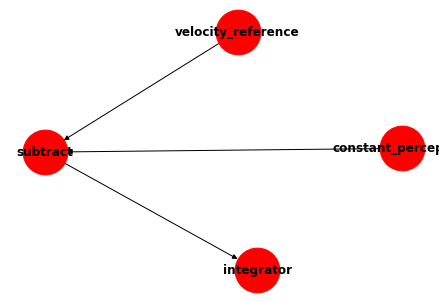

In [ ]:
g = integratingnode.graph()
nx.draw(g, with_labels=True, font_weight='bold', node_color='red',  node_size=2000)

## Running a Node

For the purposes of this example we first create a function which is a very basic model of the physical environment. It defines how the world behaves when we pass it the output of the control system.  

In [ ]:
def velocity_model(velocity,  force , mass):
    velocity = velocity + force / mass
    return velocity

mass = 50
force = 0

In the following cell we start with a velocity of zero. The node is run once (second line), the output of which is the force to apply in the world velocity_model. That returns the updated velocity which we pass back into the node to be used in the next iteration of the loop.   

In [ ]:
velocity=0
force = node()
velocity = velocity_model(velocity, force, mass)
node.set_perception_value(velocity)
print(force)
assert force == 10

10


The node can be run in a loop as shown below. With verbose set to True the output of each loop will be printed to the screen.

In [ ]:
pctnode = PCTNode(history=True)
pctnode.set_function_name("perception", "velocity")
pctnode.set_function_name("reference", "reference")

for i in range(40):
    print(i, end=" ")
    force = pctnode(verbose=True)
    vel = velocity_model(pctnode.get_perception_value(), force, mass)
    pctnode.set_perception_value(vel)
    

0 1.000 0.000 1.000 10.000 
1 1.000 0.200 0.800 8.000 
2 1.000 0.360 0.640 6.400 
3 1.000 0.488 0.512 5.120 
4 1.000 0.590 0.410 4.096 
5 1.000 0.672 0.328 3.277 
6 1.000 0.738 0.262 2.621 
7 1.000 0.790 0.210 2.097 
8 1.000 0.832 0.168 1.678 
9 1.000 0.866 0.134 1.342 
10 1.000 0.893 0.107 1.074 
11 1.000 0.914 0.086 0.859 
12 1.000 0.931 0.069 0.687 
13 1.000 0.945 0.055 0.550 
14 1.000 0.956 0.044 0.440 
15 1.000 0.965 0.035 0.352 
16 1.000 0.972 0.028 0.281 
17 1.000 0.977 0.023 0.225 
18 1.000 0.982 0.018 0.180 
19 1.000 0.986 0.014 0.144 
20 1.000 0.988 0.012 0.115 
21 1.000 0.991 0.009 0.092 
22 1.000 0.993 0.007 0.074 
23 1.000 0.994 0.006 0.059 
24 1.000 0.995 0.005 0.047 
25 1.000 0.996 0.004 0.038 
26 1.000 0.997 0.003 0.030 
27 1.000 0.998 0.002 0.024 
28 1.000 0.998 0.002 0.019 
29 1.000 0.998 0.002 0.015 
30 1.000 0.999 0.001 0.012 
31 1.000 0.999 0.001 0.010 
32 1.000 0.999 0.001 0.008 
33 1.000 0.999 0.001 0.006 
34 1.000 0.999 0.001 0.005 
35 1.000 1.000 0.000 0.004 
3

## Plotting the Data

As the history of the variable pctnode was set to True the data is available for analysis. It can be plotted with python libraries such as matplotlib or plotly. Here is an example with the latter.

The graph shows the changing perception values as it is controlled to match the reference value.

```python
import plotly.graph_objects as go
fig = go.Figure(layout_title_text="Velocity Goal")
fig.add_trace(go.Scatter(y=pctnode.history.data['refcoll']['reference'], name="ref"))
fig.add_trace(go.Scatter(y=pctnode.history.data['percoll']['velocity'], name="perc"))
```

This following code is only for the purposes of displaying image of the graph generated by the above code.

In [ ]:
from IPython.display import Image
Image(url='http://www.perceptualrobots.com/wp-content/uploads/2020/08/pct_node_plot.png') 

In [ ]:
%nbdev_hide
from nbdev import *
notebook2script()

Converted 00_examples.ipynb.
Converted 01_utilities.ipynb.
Converted 02_functions.ipynb.
Converted 03_nodes.ipynb.
Converted 04_hierarchy.ipynb.
Converted index.ipynb.
